In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils

import torchvision
import torchvision.transforms as transforms


import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
random_seed = 42
print('Random seed : {}'.format(random_seed))
random.seed(random_seed)
torch.manual_seed(random_seed)

Random seed : 42


#### 1. Loading and Normalizing MNIST

In [3]:
batch_size = 64
image_size = 28
ngpu = 1

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

In [5]:
trainset = torchvision.datasets.MNIST( '../data', train=True, transform=transform, target_transform=None, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.MNIST( '../data', train=False, transform=transform, target_transform=None, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

#### 2. Set Device

In [6]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

#### 2. Visualizing Data

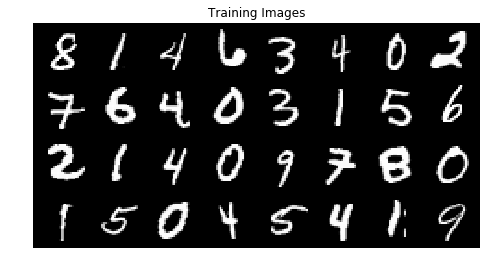

In [7]:
# Plot some training images
real_batch = next(iter(trainloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))

#### 3. Defining The Network

In [19]:
class Generator(nn.Module):
    
    def __init__(self, latent_dim, fig_size):
        super(Generator, self).__init__()
        self.g1 = nn.Linear(latent_dim, int(fig_size/4))
        self.g2 = nn.Linear(int(fig_size/4), int(fig_size/2))
        self.g3 = nn.Linear(int(fig_size/2), fig_size)
        
    def forward(self, x):
        x = F.leaky_relu(self.g1(x))
        x = F.leaky_relu(self.g2(x))
        x = self.g3(x)
        return x.view(x.size()[0],1,image_size, image_size)

In [20]:
netg = Generator(latent_dim=100, fig_size=image_size*image_size).to(device)
print(netg)

Generator(
  (g1): Linear(in_features=100, out_features=196, bias=True)
  (g2): Linear(in_features=196, out_features=392, bias=True)
  (g3): Linear(in_features=392, out_features=784, bias=True)
)


In [21]:
class Discriminator(nn.Module):
    
    def __init__(self, fig_size, num_classes):
        super(Discriminator, self).__init__()
        self.d1 = nn.Linear(fig_size, int(fig_size/2))
        self.d2 = nn.Linear(int(fig_size/2), int(fig_size/4))
        self.d3 = nn.Linear(int(fig_size/4), 1)
    
    def forward(self, x):
        x = x.view(x.size()[0],-1)
        x = F.leaky_relu(self.d1(x))
        x = F.leaky_relu(self.d2(x))
        x = torch.sigmoid(self.d3(x))
        return x

In [22]:
netd = Discriminator(fig_size=image_size*image_size, num_classes=len(trainset.classes)).to(device)
print(netd)

Discriminator(
  (d1): Linear(in_features=784, out_features=392, bias=True)
  (d2): Linear(in_features=392, out_features=196, bias=True)
  (d3): Linear(in_features=196, out_features=1, bias=True)
)


#### 3.1. Defining Parameters

In [23]:
n_epoch = 20
real_label = 1
fake_label = 0

In [24]:
criterion = nn.BCELoss()
optg = optim.Adam(netg.parameters(), lr=0.0002)
optd = optim.Adam(netd.parameters(), lr=0.0002)

#### 4. Training

In [25]:
fixed_noise = torch.randn(batch_size, 100).to(device)

In [26]:
G_losses = []
D_losses = []
img_list = []
iters = 0

for epoch in range(n_epoch):
    
    running_loss = 0.0
    
    for idx, data in enumerate(trainloader, 0):
        
        # Training the Discriminator with Real Images
        real_image, label = data
        optd.zero_grad()
        label = torch.full((real_image.size()[0],), real_label)
        output = netd(real_image.to(device))
        
        #print(output.size(), label.size())
        errD_real = criterion(output, label.to(device))
        D_x = output.mean().item()
        
        # Training the Discriminator with Fake Images
        noise = torch.randn(real_image.size()[0], 100)
        fake_image = netg(noise.to(device))
        label.fill_(fake_label)
        output = netd(fake_image.detach()).view(-1)
        errD_fake = criterion(output, label.to(device))
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        errD.backward()
        optd.step()
        
        # Training the Generator
        optg.zero_grad()
        label.fill_(real_label)
        output = netd(fake_image).view(-1)
        errG = criterion(output, label.to(device))
        errG.backward()
        D_G_z2 = output.mean().item()
        optg.step()

        # Output training stats
        if idx % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, n_epoch, idx, len(trainloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == n_epoch-1) and (idx == len(trainloader)-1)):
            with torch.no_grad():
                fake = netg(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

C:\ProgramData\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


[0/20][0/938]	Loss_D: 1.3770	Loss_G: 0.6856	D(x): 0.5123	D(G(z)): 0.5074 / 0.5038
[0/20][50/938]	Loss_D: 1.4930	Loss_G: 1.1800	D(x): 0.3895	D(G(z)): 0.4167 / 0.3082
[0/20][100/938]	Loss_D: 0.7492	Loss_G: 1.0158	D(x): 0.8391	D(G(z)): 0.4315 / 0.3639
[0/20][150/938]	Loss_D: 0.3436	Loss_G: 2.0471	D(x): 0.8925	D(G(z)): 0.1988 / 0.1353
[0/20][200/938]	Loss_D: 0.3229	Loss_G: 3.1313	D(x): 0.8097	D(G(z)): 0.0945 / 0.0480
[0/20][250/938]	Loss_D: 0.5709	Loss_G: 2.8282	D(x): 0.7643	D(G(z)): 0.2438 / 0.0663
[0/20][300/938]	Loss_D: 0.2664	Loss_G: 4.3213	D(x): 0.8469	D(G(z)): 0.0851 / 0.0187
[0/20][350/938]	Loss_D: 0.4693	Loss_G: 3.6769	D(x): 0.7140	D(G(z)): 0.0886 / 0.0328
[0/20][400/938]	Loss_D: 1.2920	Loss_G: 3.5470	D(x): 0.4677	D(G(z)): 0.2960 / 0.0395
[0/20][450/938]	Loss_D: 0.8445	Loss_G: 3.3243	D(x): 0.6145	D(G(z)): 0.2293 / 0.0479
[0/20][500/938]	Loss_D: 0.3331	Loss_G: 3.3341	D(x): 0.8152	D(G(z)): 0.1005 / 0.0431
[0/20][550/938]	Loss_D: 0.4702	Loss_G: 2.6967	D(x): 0.7794	D(G(z)): 0.1516 / 0.

C:\ProgramData\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


[1/20][0/938]	Loss_D: 0.5870	Loss_G: 2.3412	D(x): 0.8291	D(G(z)): 0.1894 / 0.1028
[1/20][50/938]	Loss_D: 0.5114	Loss_G: 2.4122	D(x): 0.8291	D(G(z)): 0.1824 / 0.0953
[1/20][100/938]	Loss_D: 0.0990	Loss_G: 3.6230	D(x): 0.9713	D(G(z)): 0.0657 / 0.0287
[1/20][150/938]	Loss_D: 0.0997	Loss_G: 3.4947	D(x): 0.9767	D(G(z)): 0.0703 / 0.0361
[1/20][200/938]	Loss_D: 0.1777	Loss_G: 3.4997	D(x): 0.9394	D(G(z)): 0.0798 / 0.0322
[1/20][250/938]	Loss_D: 0.0759	Loss_G: 4.5026	D(x): 0.9793	D(G(z)): 0.0469 / 0.0127
[1/20][300/938]	Loss_D: 0.4655	Loss_G: 5.0673	D(x): 0.8796	D(G(z)): 0.1478 / 0.0385
[1/20][350/938]	Loss_D: 0.9215	Loss_G: 3.6764	D(x): 0.7710	D(G(z)): 0.2300 / 0.0731
[1/20][400/938]	Loss_D: 0.3648	Loss_G: 3.9502	D(x): 0.9048	D(G(z)): 0.1550 / 0.0359
[1/20][450/938]	Loss_D: 0.2530	Loss_G: 3.9534	D(x): 0.9221	D(G(z)): 0.0695 / 0.0374
[1/20][500/938]	Loss_D: 0.3817	Loss_G: 3.2225	D(x): 0.9019	D(G(z)): 0.1480 / 0.0568
[1/20][550/938]	Loss_D: 0.1309	Loss_G: 4.7870	D(x): 0.9580	D(G(z)): 0.0672 / 0.

[11/20][200/938]	Loss_D: 0.1684	Loss_G: 6.2145	D(x): 0.9151	D(G(z)): 0.0223 / 0.0074
[11/20][250/938]	Loss_D: 0.1415	Loss_G: 6.7460	D(x): 0.9342	D(G(z)): 0.0223 / 0.0153
[11/20][300/938]	Loss_D: 0.0665	Loss_G: 5.9565	D(x): 0.9802	D(G(z)): 0.0396 / 0.0145
[11/20][350/938]	Loss_D: 0.3963	Loss_G: 6.3876	D(x): 0.8732	D(G(z)): 0.0151 / 0.0078
[11/20][400/938]	Loss_D: 0.2356	Loss_G: 6.0113	D(x): 0.9131	D(G(z)): 0.0282 / 0.0179
[11/20][450/938]	Loss_D: 0.2336	Loss_G: 5.6835	D(x): 0.9224	D(G(z)): 0.0402 / 0.0251
[11/20][500/938]	Loss_D: 0.1246	Loss_G: 4.5228	D(x): 0.9698	D(G(z)): 0.0640 / 0.0297
[11/20][550/938]	Loss_D: 0.2415	Loss_G: 5.4166	D(x): 0.9303	D(G(z)): 0.0451 / 0.0287
[11/20][600/938]	Loss_D: 0.0976	Loss_G: 6.2070	D(x): 0.9558	D(G(z)): 0.0274 / 0.0097
[11/20][650/938]	Loss_D: 0.4163	Loss_G: 5.2221	D(x): 0.8691	D(G(z)): 0.0878 / 0.0306
[11/20][700/938]	Loss_D: 0.1591	Loss_G: 5.7524	D(x): 0.9377	D(G(z)): 0.0351 / 0.0287
[11/20][750/938]	Loss_D: 0.1464	Loss_G: 4.8523	D(x): 0.9454	D(G(z

#### 5. Output

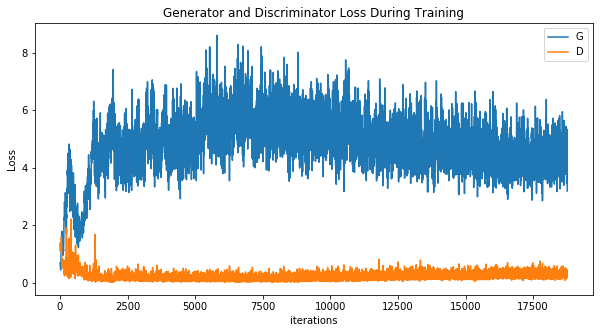

In [27]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

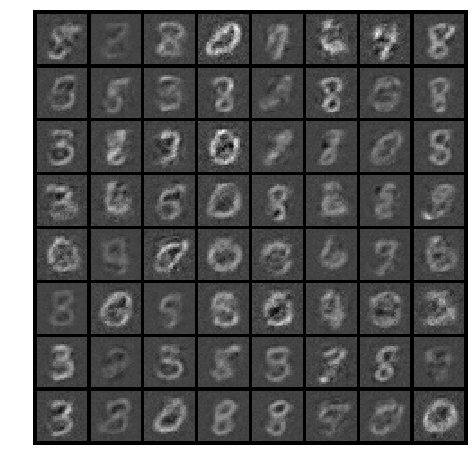

In [28]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

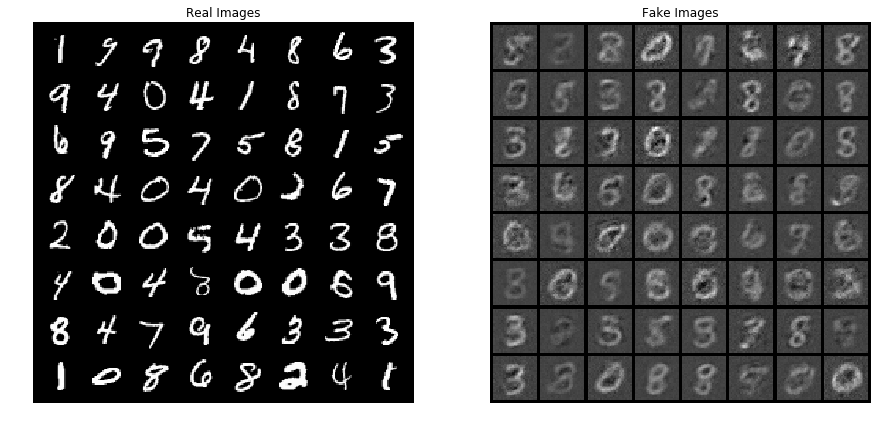

In [29]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(trainloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[38].to(device)[:10], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()